In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.base import BaseEstimator
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.special import softmax
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
data_transform = transforms.Compose([transforms.ToTensor(),])

In [3]:
def get_data(data, indices=None, binarize=True):
    '''
    The EMNIST images provided here are inverted horizontally and rotated 90 anti-clockwise.
    Thus we will rotate the image back by 90 deg anti-clockwise
    '''
    N = len(data)
    if indices is None:
        indices = range(0, N)
    #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
    X = np.stack([data[i][0].numpy().transpose(0,2,1) for i in indices], axis=1).squeeze(0) # (N,28,28)
    if binarize: 
        X = (X > 0.5).astype(int)
    #y = torch.tensor([data[i][1] for i in indices])
    y = np.array([data[i][1] for i in indices])
    return X, y

In [4]:
datasets.EMNIST.url = 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
data = datasets.EMNIST(
    root="~/CS535/MiniProject/data",
    split="balanced",
    download=False,
    transform=data_transform
)

In [5]:
X, y = get_data(data)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
# print(f"Length of training set: {len(X_train)}, Length of test set: {len(X_test)}")

In [6]:
print(f"Dataset size: {len(X)}")

Dataset size: 112800


In [7]:
LABELS = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 
          10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M',
          23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z',
          36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}

### **Task 1:** Display samples from this dataset in a 5 x C table: columns correspond to character IDs, rows to five random samples from the same category.

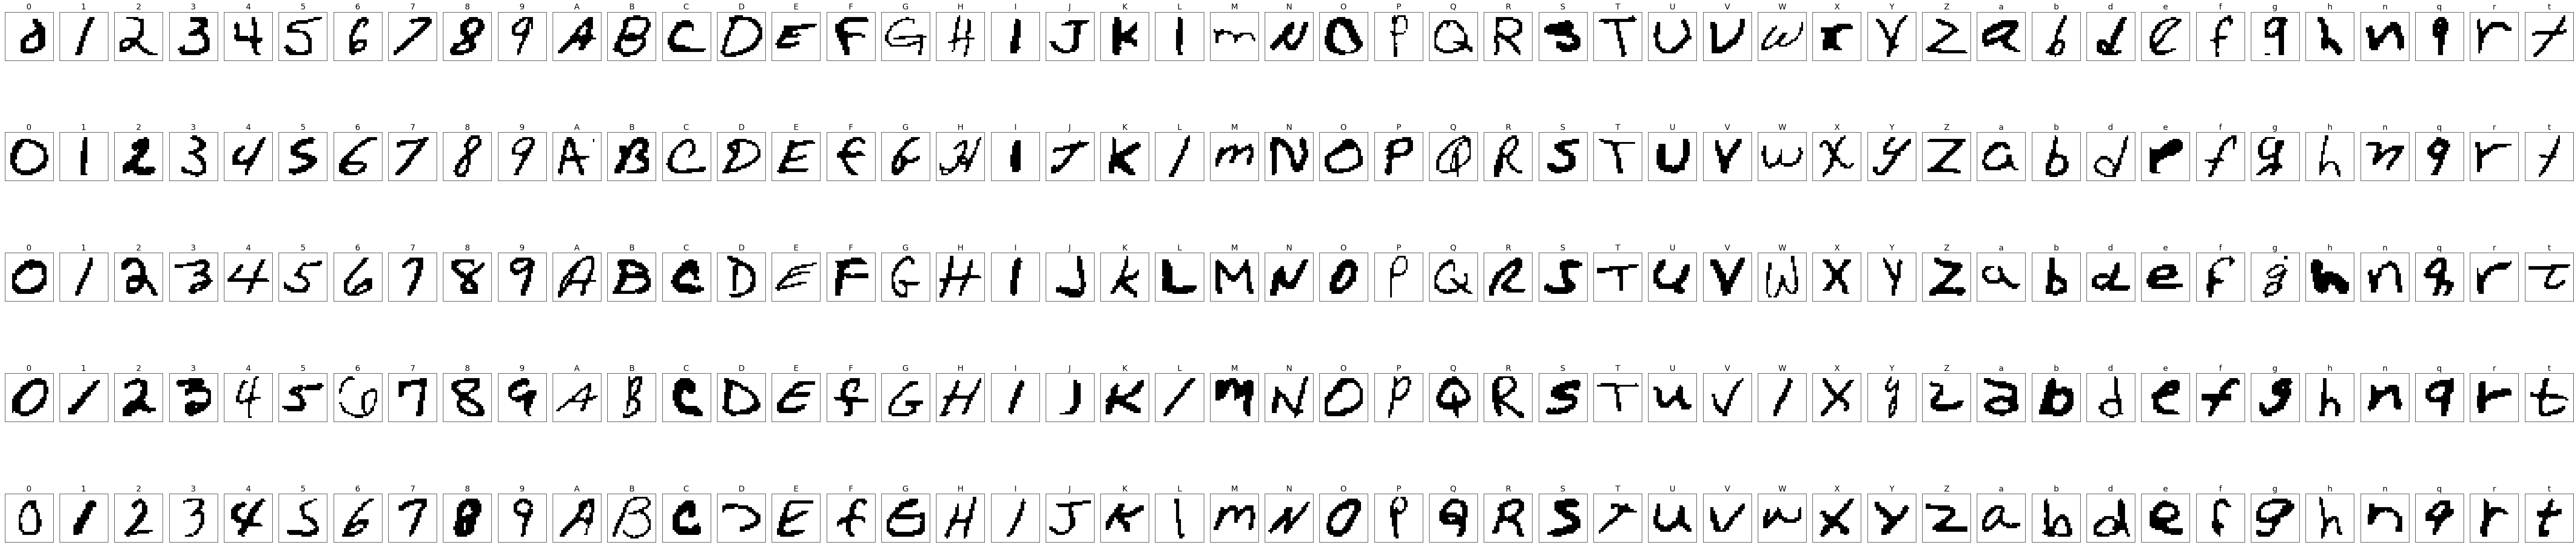

In [8]:
figure = plt.figure(figsize=(80, 20))
cols, rows = 47, 5
for i in range(1, cols * rows + 1):
    _id = (i-1) % cols
    indexes = np.where(y == _id)[0].tolist()
    sample_idx = np.random.choice(indexes)
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    label = LABELS[label]
    plt.title(label, fontsize=18)
    #plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

plt.tight_layout()
#plt.savefig("EMNIST_sample.png",dpi=300)
plt.show()

### **Task 2.1:** Implement two learning paradigms, MLE and MAP for model parameters, i.e., $p(\Theta|\mathcal{D},\alpha,\beta)$, as an Estimator Fit method
### **Task 2.2:** Then implement predictive models based on each type of learning, i.e., $p(x|\mathcal{D},\alpha,\beta)=\int p(x|\Theta)p(\Theta|\mathcal{D},\alpha,\beta)d\Theta$, as Estimator Predict method
### **Task 2.3:** Also implement the scoring methods for the two models, $$\frac{1}{|D|}log p(\mathcal{D}|\alpha,\beta)=\frac{1}{|D|}log\int p(\mathcal{D}|\Theta)p(\Theta|\alpha,\beta)d\Theta$$, as Estimator Score/Model method, where $|\mathcal{D}|$ denotes the dataset size

#### **MLE**

In [9]:
class MLE(BaseEstimator):
    def __init__(self):
        self.Py_mle = None
        self.theta_hat_mle_ = None
    
    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=False, allow_nd=True)
        self.classes_ = unique_labels(y)
        
        # fit Py
        n_classes = np.zeros(len(self.classes_))
        for i in range(len(self.classes_)):
            n_classes[i] = (y == i).sum()
        self.Py_mle = n_classes / n_classes.sum()
        
        # fit theta_hat
        _, h, w = X.shape
        self.theta_hat_mle_ = np.zeros((len(self.classes_), h, w))
        for i in range(len(self.classes_)):
            current_set = X[np.where(y == i)]
            # laplace smoothing to account for all 0's and all 1's for a given pixel distribution
            self.theta_hat_mle_[i] = (np.sum(current_set, axis=0) + 1) / (len(current_set) + 2)
    
    def predict(self, X):
        check_is_fitted(self)
        X = X.reshape(-1,784)
        log_Py = np.log(self.Py_mle.reshape(1,-1))
        log_theta = np.log(self.theta_hat_mle_.reshape(-1,784))
        log_theta_neg = np.log(1 - self.theta_hat_mle_.reshape(-1,784))
        loglik = log_Py + (X@log_theta.T + (1-X)@log_theta_neg.T)
        return np.argmax(loglik, axis = 1)
    
    def score(self, X, y):
        assert len(X) == len(y), f"X and y have different shapes: {len(X)}, {len(y)}"
        data_size = len(X)
        parts = list(np.arange(0, data_size, data_size//4)) + [data_size]
        corr_pred = 0
        for i in range(1, len(parts)):
            current_set = X[parts[i-1] : parts[i]]
            current_target = y[parts[i-1] : parts[i]]
            corr_pred += (self.predict(current_set) == current_target).sum()
        return corr_pred / data_size

#### **MAP**

In [10]:
class MAP(BaseEstimator):
    def __init__(self, alpha, beta):
        self.Py_map = None
        self.theta_hat_map_ = None
        self.alpha = alpha
        self.beta = beta
        self.beta1 = self.beta2 = self.beta
    
    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=False, allow_nd=True)
        self.classes_ = unique_labels(y)
        
        # fit Py
        n_classes = np.zeros(len(self.classes_))
        for i in range(len(self.classes_)):
            n_classes[i] = (y == i).sum()
        self.Py_map = (n_classes + self.alpha)/(n_classes + self.alpha).sum()
        
        # fit theta_hat
        _, h, w = X.shape
        self.theta_hat_map_ = np.zeros((len(self.classes_), h, w))
        for i in range(len(self.classes_)):
            current_set = X[np.where(y == i)]
            if self.beta >= 2:
                self.theta_hat_map_[i] = (np.sum(current_set, axis=0) + self.beta1 - 1) / (len(current_set) + self.beta1 + self.beta2 - 2)
            # add smoothing for all white/black pixels when beta <= 2
            else:
                self.theta_hat_map_[i] = (np.sum(current_set, axis=0) + self.beta1 - 1 + 1) / (len(current_set) + self.beta1 + self.beta2 - 2 + 2)
    
    def predict(self, X):
        check_is_fitted(self)
        X = X.reshape(-1,784)
        log_Py = np.log(self.Py_map.reshape(1,-1))
        log_theta = np.log(self.theta_hat_map_.reshape(-1, 784))
        log_theta_neg = np.log(1 - self.theta_hat_map_.reshape(-1, 784))
        loglik = log_Py + (X@log_theta.T + (1-X)@log_theta_neg.T)
        return np.argmax(loglik, axis = 1)
    
    def score(self, X, y):
        assert len(X) == len(y), f"X and y have different shapes: {len(X)}, {len(y)}"
        data_size = len(X)
        parts = list(np.arange(0, data_size, data_size//4)) + [data_size]
        corr_pred = 0
        for i in range(1, len(parts)):
            current_set = X[parts[i-1] : parts[i]]
            current_target = y[parts[i-1] : parts[i]]
            corr_pred += (self.predict(current_set) == current_target).sum()
        return corr_pred / data_size

### **3.** Plotting the Learning Curves for (almost) Balanced Training Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=0)

In [12]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5)
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt

### **Task 3.1:** Fix the pixel prior $\beta = 1$ and plot the training and validation curves for $\alpha = (1, 10, 50, 100, 200)$

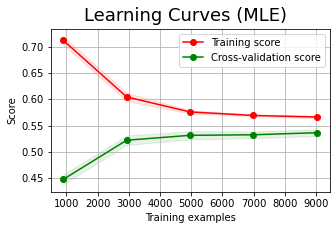

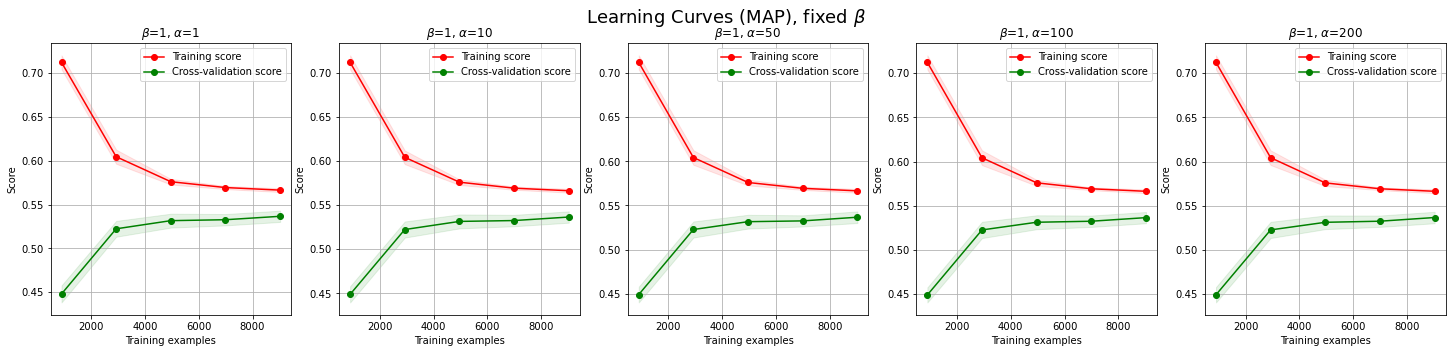

In [13]:
beta = 1
alpha = [1, 10, 50, 100, 200]

# MLE plot, no priors for MLE
MLE_estimator = MLE()
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
fig.suptitle(r"Learning Curves ({})".format('MLE'), fontsize=18)
title = " "
plot_learning_curve(MLE_estimator, title, X_train, y_train, axes, n_jobs=4, scoring="accuracy")
plt.show()

# MAP Plot, different plots for different value of priors
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle(r"Learning Curves ({}), fixed $\beta$".format('MAP'), fontsize=18)
for a, ax in zip(alpha, axes.flatten()):
    MAP_estimator = MAP(a, beta)
    title = r"$\beta$={}, $\alpha$={}".format(beta, a)
    plot_learning_curve(MAP_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
plt.show()

### **Task 3.2:** Fix the pixel prior $\alpha = 1$ and plot the training and validation curves for $\beta = (1, 2, 10, 100)$

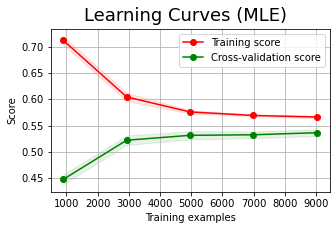

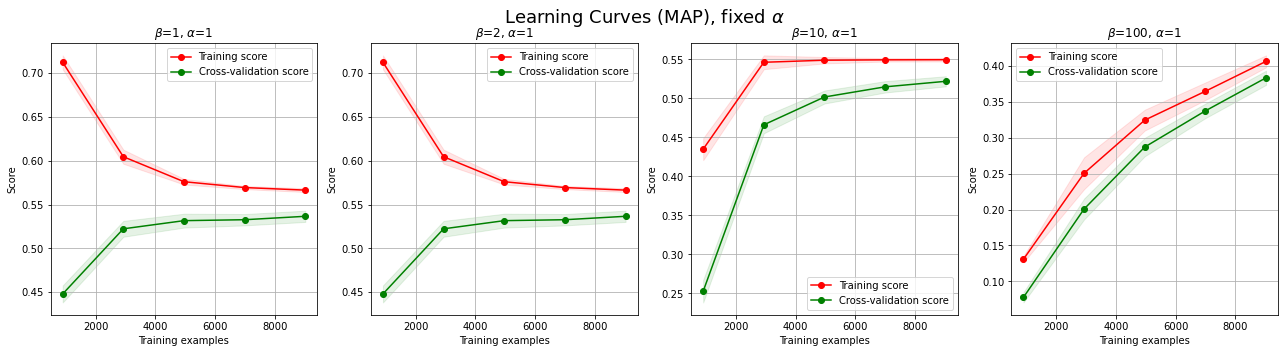

In [14]:
alpha = 1
beta = [1, 2, 10, 100]

# MLE plot, no priors for MLE
MLE_estimator = MLE()
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
fig.suptitle(r"Learning Curves ({})".format('MLE'), fontsize=18)
title = " "
plot_learning_curve(MLE_estimator, title, X_train, y_train, axes, n_jobs=4, scoring="accuracy")
plt.show()

# MAP Plot, different plots for different value of priors
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.suptitle(r"Learning Curves ({}), fixed $\alpha$".format('MAP'), fontsize=18)
for b, ax in zip(beta, axes.flatten()):
    MAP_estimator = MAP(alpha, b)
    title = r"$\beta$={}, $\alpha$={}".format(b, alpha)
    plot_learning_curve(MAP_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
plt.show()

### **Task 4:** Construct imbalanced training data

In [15]:
def sample_data(alpha_class, train_length, X, y):
    np.random.seed(0)
    
    prob = np.random.dirichlet(np.ones(47)*alpha_class)
    label_dist = (prob * 11280).clip(2, (len(y)//47)-2).astype(int)
    d = train_length - label_dist.sum()

    # ensure training data size matches sampled data size
    # if sampled data size is less than required training length
    if d > 0:
        # select labels that have higher values
        choices = np.where(label_dist < 2000)[0]
        # divide the difference with number of indexes to add samples to selected labels
        to_add = d//len(choices)
        label_dist[choices] = label_dist[choices] + to_add
        # get remaining values after adding
        rem = d%len(choices)
        # randomly sample labels to add remaining values
        if rem > 0:
            choices = np.random.choice(np.arange(47), size=rem, replace=False)
            label_dist[choices] = label_dist[choices] + 1
    
    # if sampled data size is more than required training length
    elif d < 0:
        # select labels that have values more than half of maximum label count
        choices = np.where(label_dist > np.max(label_dist)//2)[0]
        # divide the difference with number of indexes to subtract samples from selected labels
        to_sub = (-1*d)//len(choices)
        label_dist[choices] = label_dist[choices] - to_sub
        # get remaining values after subtracting
        rem = (-1*d)%len(choices)
        # randomly sample labels to subtract remaining values
        if rem > 0:
            choices = np.random.choice(np.arange(47), size=rem, replace=False)
            label_dist[choices] = label_dist[choices] - 1

    assert all(label_dist > 0), f'0 samples selected for class labels: {np.where(label_dist == 0)[0]}'
    assert len(np.where(label_dist >= len(y)//47)[0]) == 0, f'class data overflow for labels: {np.where(label_dist >= len(y)//47)[0]}'
    assert (train_length == label_dist.sum()), f'length mismatch in sampled data, train_length: {train_length}, sampled_size: {label_dist.sum()}'

    # collect samples
    X_sampled_train = np.zeros((train_length, 28, 28), dtype=X.dtype)
    y_sampled_train = np.zeros((train_length), dtype=X.dtype)
    train_indexes = []
    start = 0
    for label, label_count in enumerate(label_dist):
        indexes = np.where(y == label)[0]
        selected_indexes = np.random.choice(a=indexes, size=label_count, replace=False)
        X_sampled_train[start : start+label_count] = X[selected_indexes]
        y_sampled_train[start : start+label_count] = y[selected_indexes]
        train_indexes += selected_indexes.tolist()
        start += label_count
    X_sampled_test = np.delete(X, train_indexes, axis=0)
    y_sampled_test = np.delete(y, train_indexes, axis=0)
    
    # shuffle train dataset
    X_sampled_train, y_sampled_train = shuffle(X_sampled_train, y_sampled_train, random_state=0)
    
    return X_sampled_train, X_sampled_test, y_sampled_train, y_sampled_test

### **Task 4.1:** For MAP model, fix the class prior $\alpha = 1$ and try $\beta = (1, 1.2, 2, 10, 100)$  for $\alpha_{class} = (0.1, 0.2, 0.5, 1, 10, 100)$ . Plot the training & validation learning curves and compare its performance with the MLE model

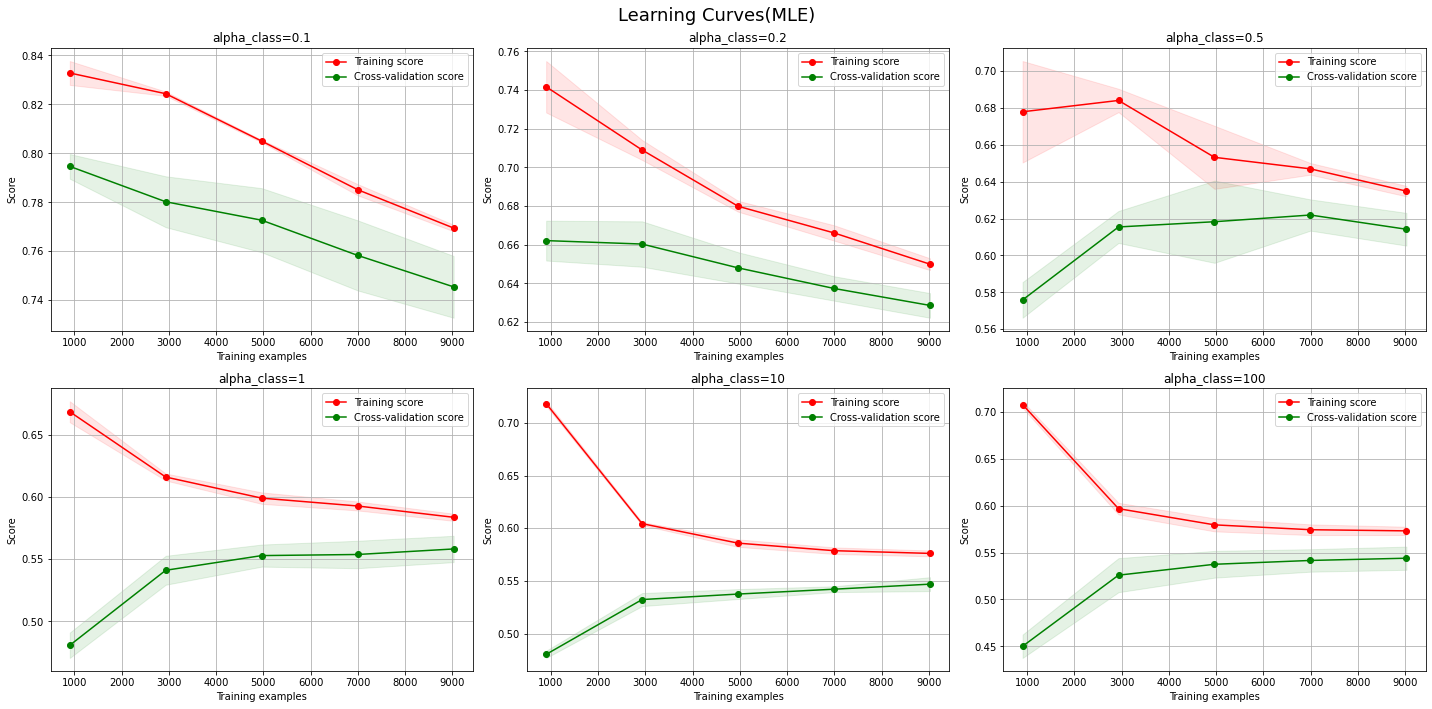

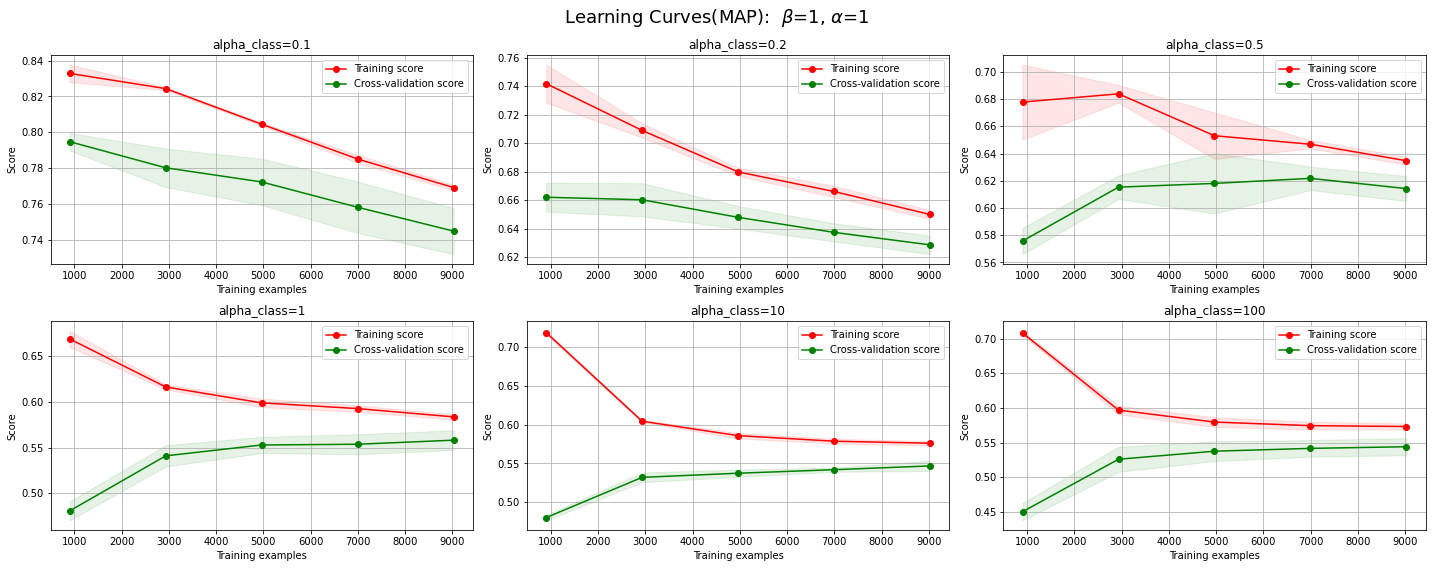

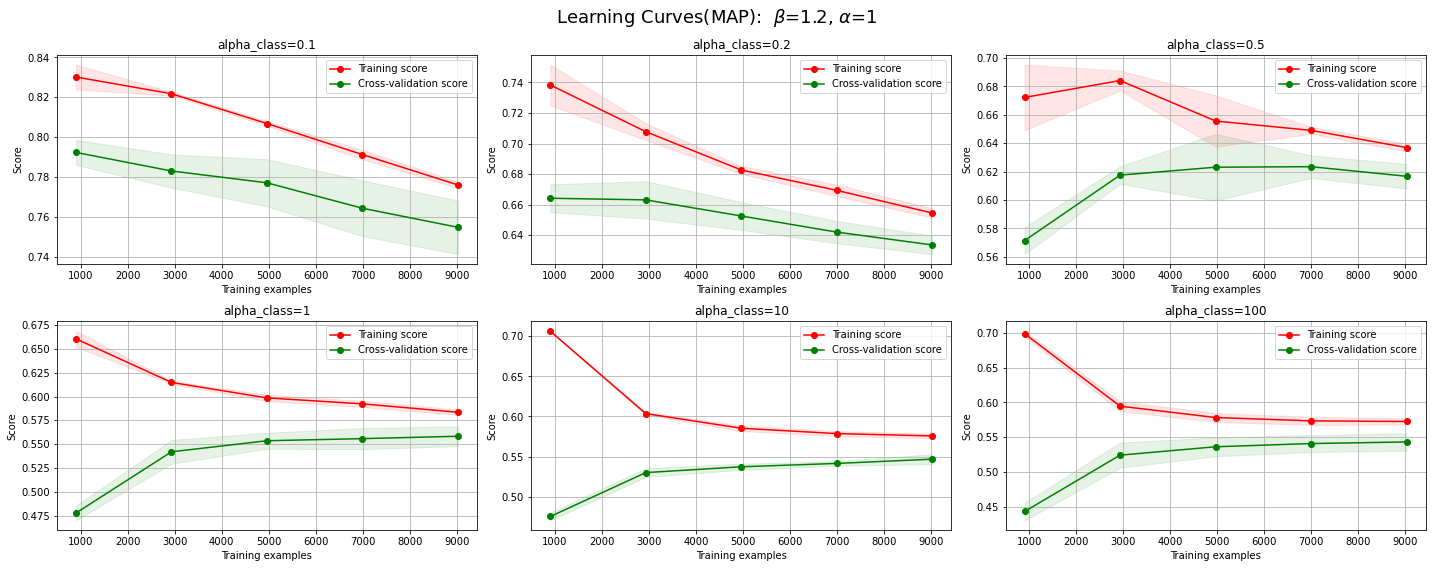

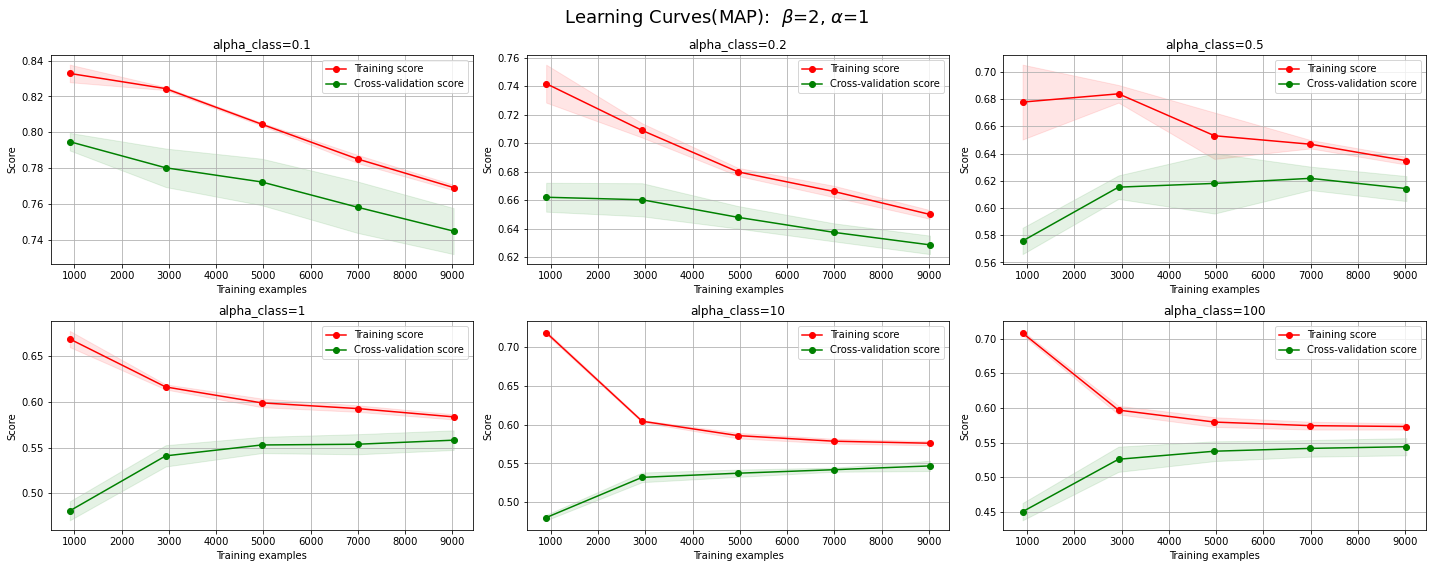

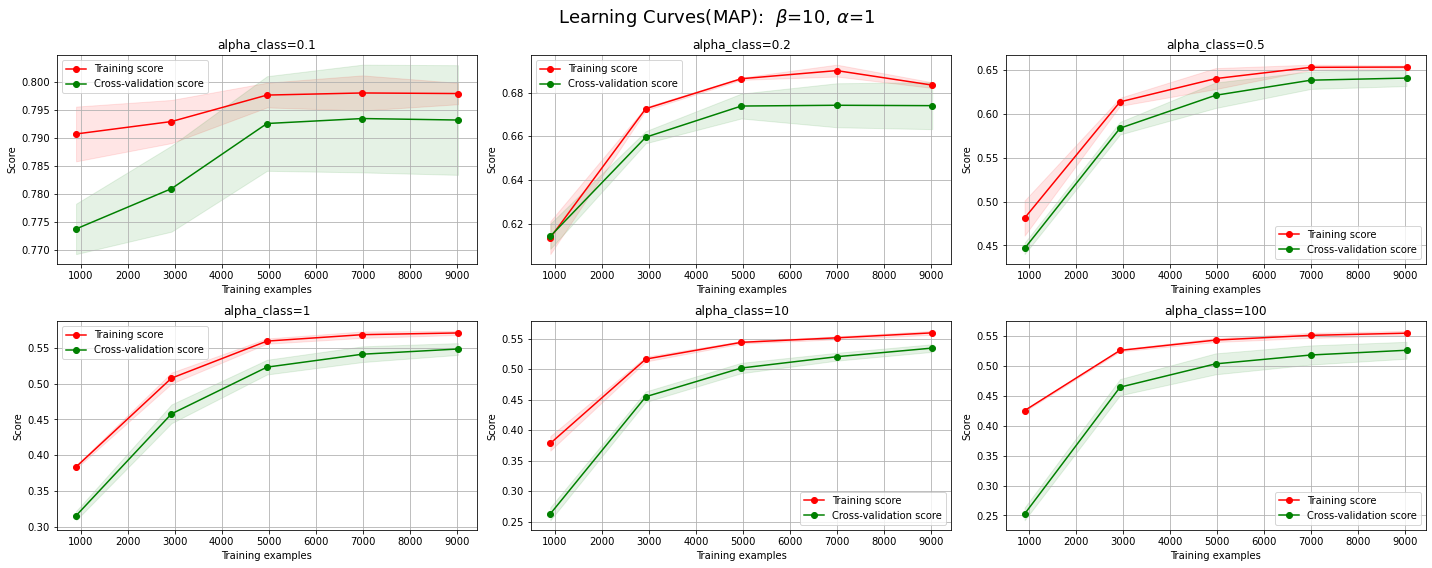

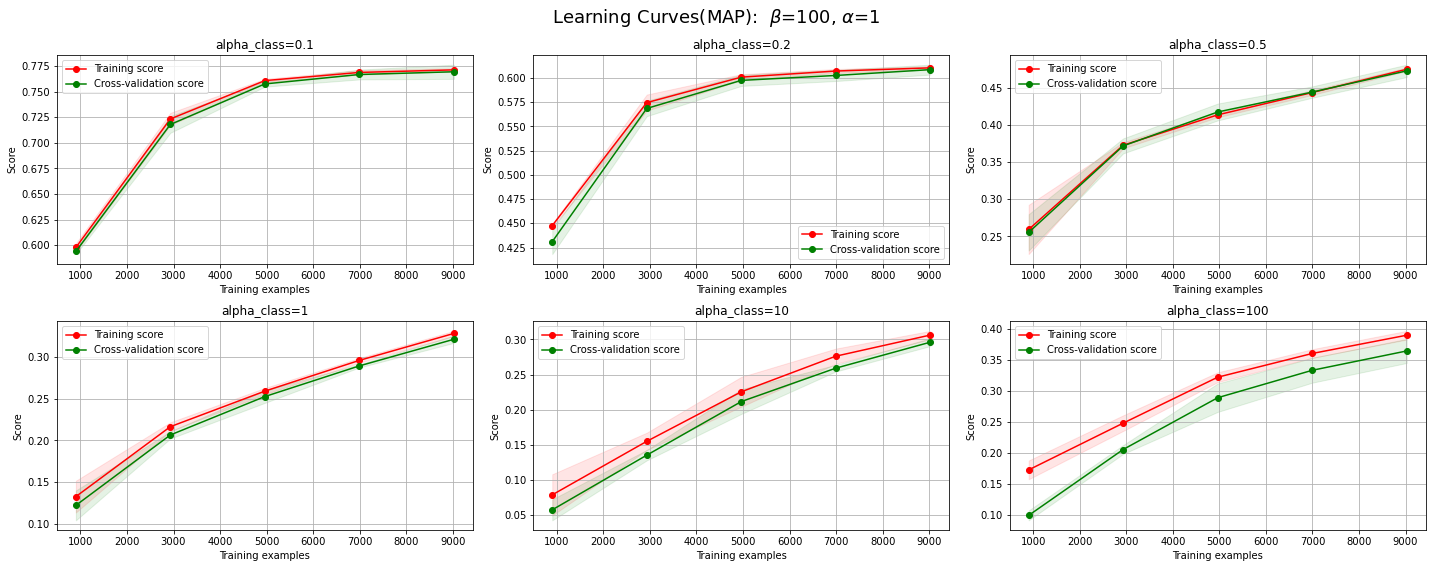

In [16]:
alpha = 1
beta = [1, 1.2, 2, 10, 100]
alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
train_length = 11280

# MLE Plot, no priors hence only one plot per alpha_class
MLE_estimator = MLE()
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle(r"Learning Curves({})".format('MLE'), fontsize=18)
for a_cls, ax in zip(alpha_class, axes.flatten()):
    X_train, X_test, y_train, y_test = sample_data(a_cls, train_length, X, y)
    title = r"alpha_class={}".format(a_cls)
    plot_learning_curve(MLE_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
plt.tight_layout()
plt.show()

# MAP Plot, different plots for different value of priors
for b in beta:
    MAP_estimator = MAP(alpha, b)
    fig, axes = plt.subplots(2, 3, figsize=(20, 8))
    fig.suptitle(r"Learning Curves({}):  $\beta$={}, $\alpha$={}".format('MAP', b, alpha), fontsize=18)
    for a_cls, ax in zip(alpha_class, axes.flatten()):
        X_train, X_test, y_train, y_test = sample_data(a_cls, train_length, X, y)
        title = r"alpha_class={}".format(a_cls)
        plot_learning_curve(MAP_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
    plt.tight_layout()
    plt.show()

### **Task 4.2:** For MAP model, fix the class prior $\beta = 1$ and try $\alpha = (1, 10, 100, 1000)$  for $\alpha_{class} = (0.1, 0.2, 0.5, 1, 10, 100)$ . Plot the training & validation learning curves and compare its performance with the MLE model

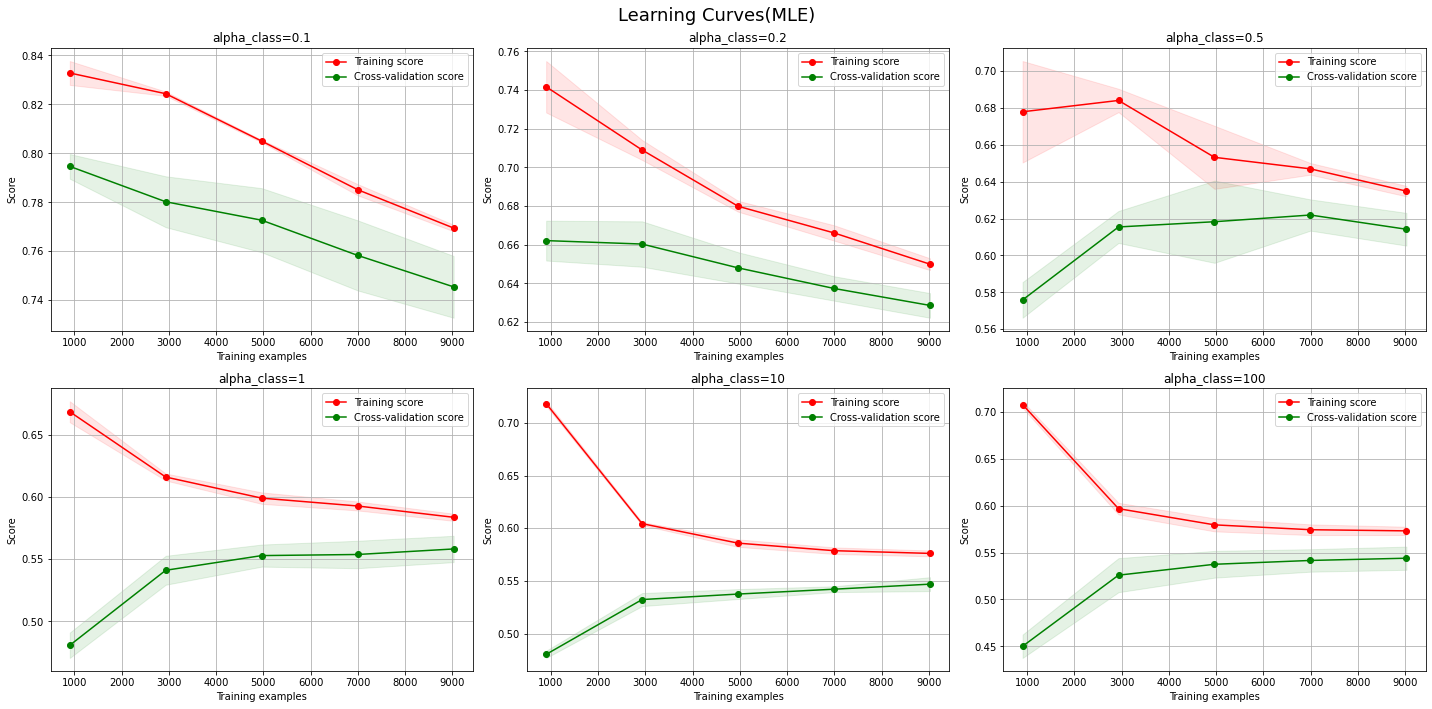

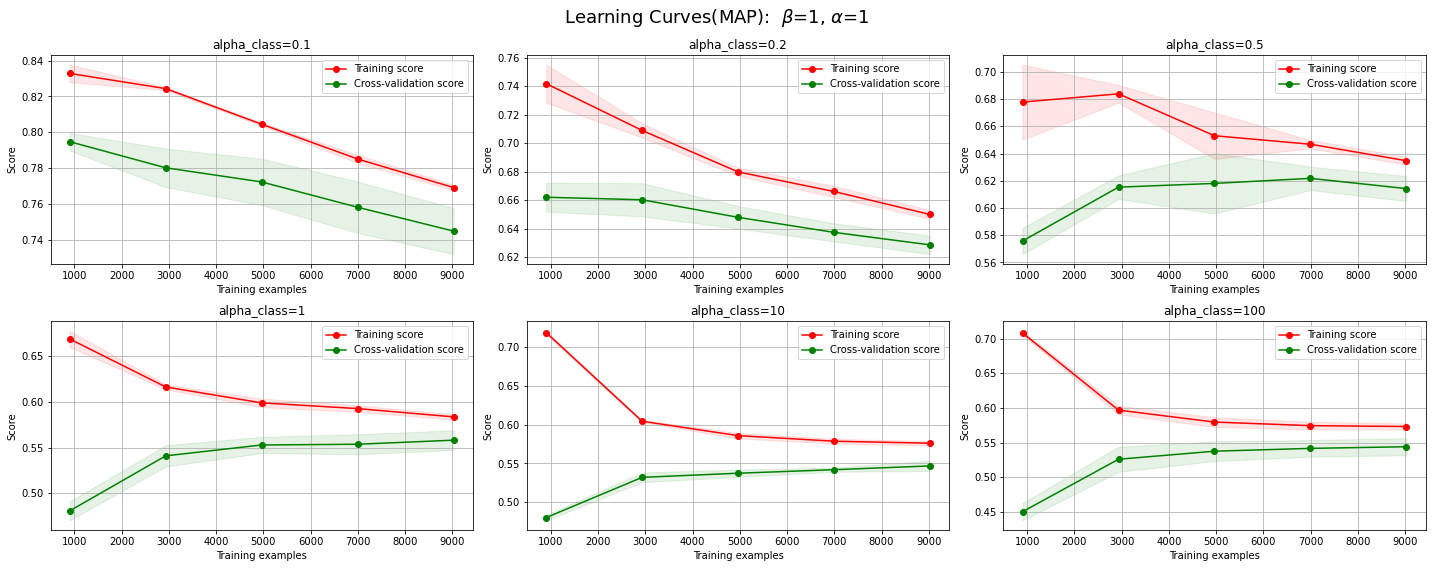

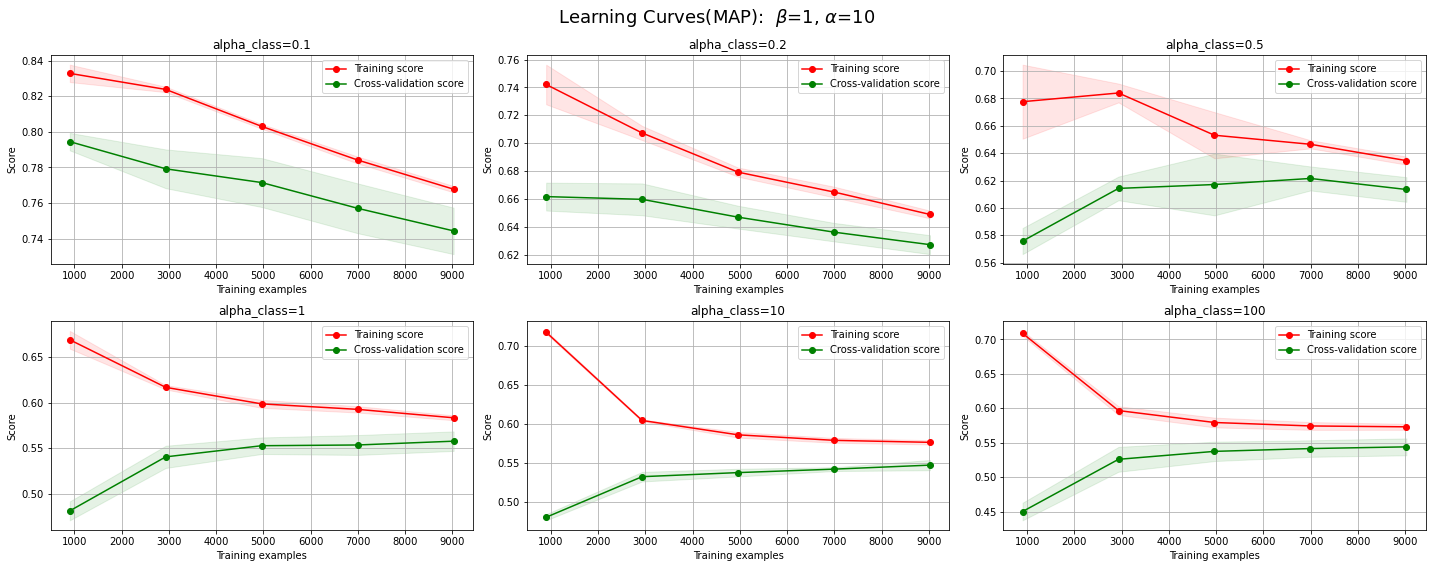

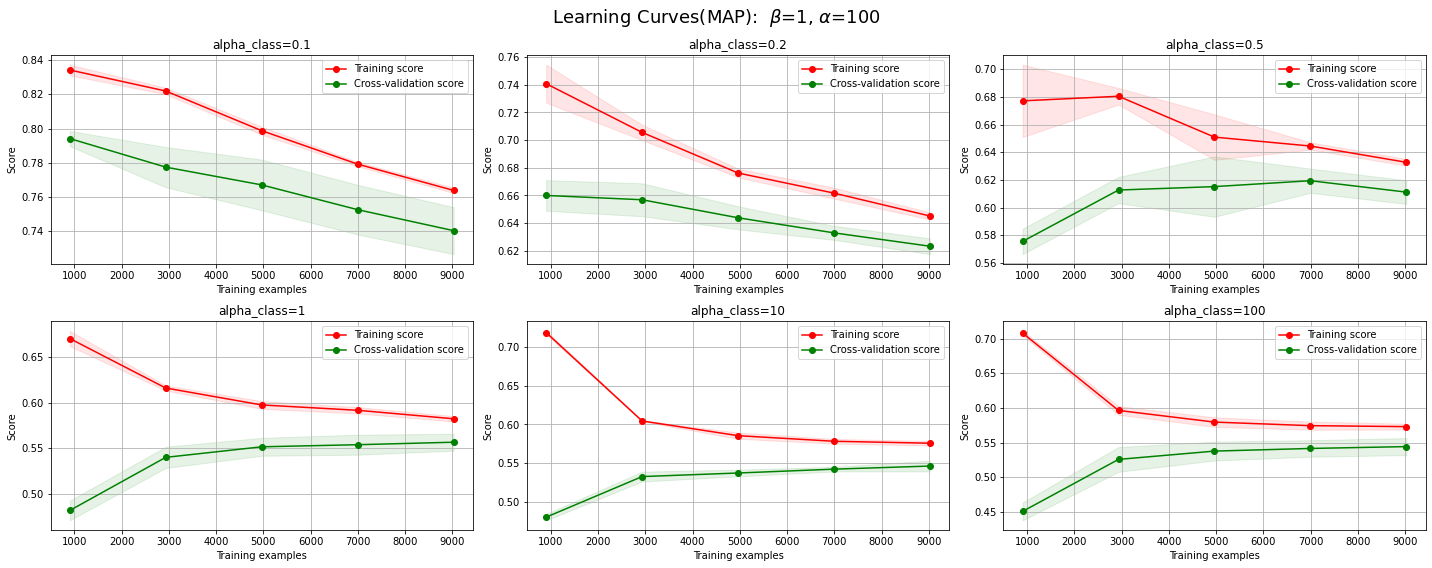

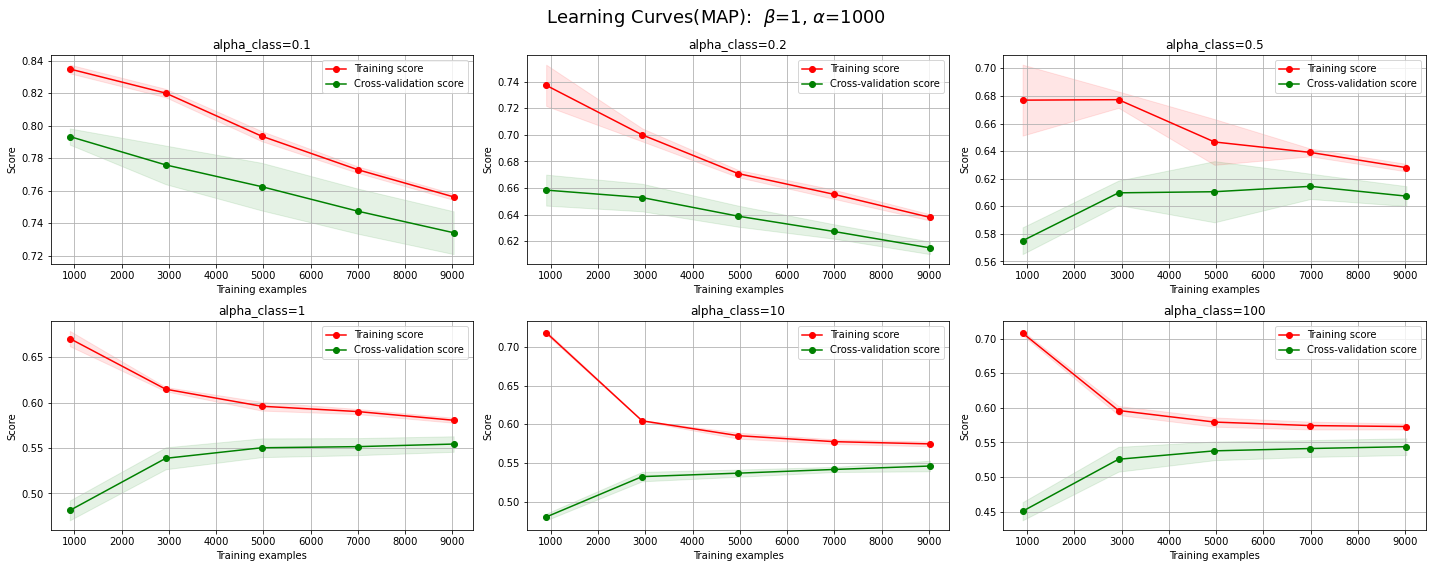

In [17]:
beta = 1
alpha = [1, 10, 100, 1000]
alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
train_length = 11280

# MLE Plot, no priors hence only one plot per alpha_class
MLE_estimator = MLE()
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle(r"Learning Curves({})".format('MLE'), fontsize=18)
for a_cls, ax in zip(alpha_class, axes.flatten()):
    X_train, X_test, y_train, y_test = sample_data(a_cls, train_length, X, y)
    title = r"alpha_class={}".format(a_cls)
    plot_learning_curve(MLE_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
plt.tight_layout()
plt.show()

# MAP Plot, different plots for different value of priors
for a in alpha:
    MAP_estimator = MAP(a, beta)
    fig, axes = plt.subplots(2, 3, figsize=(20, 8))
    fig.suptitle(r"Learning Curves({}):  $\beta$={}, $\alpha$={}".format('MAP', beta, a), fontsize=18)
    for a_cls, ax in zip(alpha_class, axes.flatten()):
        X_train, X_test, y_train, y_test = sample_data(a_cls, train_length, X, y)
        title = r"alpha_class={}".format(a_cls)
        plot_learning_curve(MAP_estimator, title, X_train, y_train, ax, n_jobs=4, scoring="accuracy")
    plt.tight_layout()
    plt.show()

### **Task 5:** Discussion

#### **Task 5.1:** How does the generalization performance of each model change as a function of the amount of training data and the choice of hyper-parameters?

**Balanced Dataset** </br>
   - **MLE**
    `We observe that MLE's training score is high at the beginning, however both training and cross-validation score is low towards the end. As the training examples increase, cross-validation score also increases with a decrease in training score.`
   - **MAP**
       - **Fixed Beta ($\beta=1$):**
    `MAP gives similar performance as MLE with fixed beta value. alpha does not seem to impact the performance of MAP as it has similar score curve for different alpha's and training examples.`
       - **Fixed Alpha ($\alpha=1$):**
    `As we have added smoothing in MLE and MAP to consider for pixels with all 0/1's, both MLE and MAP behave similarly during estimation of Pxy (for beta <= 2) and thus they have similar scores. With increase in beta value, although the score increases with increase in training examples, but overall score drops down giving bad performance for both training and cross-validation.`

**Imbalanced Dataset** </br>
   - **MLE**
    `We observe that for higher degree of imbalance, as the training size increases, both training and cross-validation score goes down. As the degree of balance increases, overall training and cross-validation score also decreases. However, for increasing degree of balance, with more training examples the cross-validation score increases.`
   - **MAP**
       - **Fixed Beta ($\beta=1$):**
     `MAP results in similar performace as MLE with fixed beta. alpha value seems to have no to little impact on score of MAP for both training and cross-validation.`
       - **Fixed Alpha ($\alpha=1$):**
     `For higher degree of imbalance, as the training size grows, increasing beta value (upto 10) increases the score of both training and cross-validation. However as the dataset become more balanced, increasing beta value decreases overall performance. We also observe that for a given degree of imbalance/balance as the training size increases, both training and cross-validation score also increases. Increasing beta value beyond a point drastically decreases overall performance.`

#### **Task 5.2:** Which model would you select for deployment and why?

> For the reasons discussed below, I would chose to deploy **MAP** model with optimal value of $\beta$

- We can clearly observe that prior information $\beta$ (MAP) plays a vital role for imbalanced dataset, however, with increasing degree of balance it does not provide much help.
- MLE and MAP have similar performance for balanced dataset, with MAP performing better as compared to MLE on imbalanced data for increasing value of $\beta \leq 10$.
- $\alpha$ does not seem to have much impact on score of MAP based estimator.

---
### Extras
---

In [ ]:
        
    def predict_old(self, X):
        check_is_fitted(self)
        axis = (1,2)
        if X.ndim > 2:
            X = X[:,np.newaxis,:,:]
            axis = (2,3)
        log_Py = np.log(self.Py_mle)
        log_theta = np.log(self.theta_hat_mle_)
        log_theta_neg = np.log(1 - self.theta_hat_mle_)
        P_xy = X*log_theta + (1-X)*log_theta_neg
        P_xy = np.sum(P_xy, axis=axis)
        # print(np.round(softmax(log_Py + P_xy),5))
        return np.argmax(log_Py + P_xy, axis = 1 if X.ndim > 2 else 0)

##### **MLE Extras**

In [ ]:
MLE_estimator = MLE()
MLE_estimator.fit(X_train, y_train)

test_class_acc = {}
train_class_acc = {}
for idx in range(len(LABELS)):
    test_class_acc[LABELS[idx]]= round((MLE_estimator.predict(X_test[np.where(y_test == idx)]) == idx).sum()/(y_test==idx).sum(),3)
    train_class_acc[LABELS[idx]]= round((MLE_estimator.predict(X_train[np.where(y_train == idx)]) == idx).sum()/(y_train==idx).sum(),3)

x = np.arange(len(LABELS))
plt.figure(figsize=(40,10))
plt.bar(x = x-0.2, height = list(train_class_acc.values()), width=0.4, label='Train')
plt.bar(x = x+0.2, height = list(test_class_acc.values()), width=0.4, label='Test')
plt.xticks(x, list(LABELS.values()))
plt.legend()
plt.title("Class Accuracy [MLE]")
plt.show()

In [ ]:
train_acc = MLE_estimator.score(X_train, y_train)
test_acc = MLE_estimator.score(X_test, y_test)
print(f'train_acc: {train_acc}, test_acc: {test_acc}')

##### **MAP Extras**

In [ ]:
MAP_estimator = MAP(alpha = 1, beta = 2)
MAP_estimator.fit(X_train, y_train)

test_class_acc = {}
train_class_acc = {}
for idx in range(len(LABELS)):
    test_class_acc[LABELS[idx]]= round((MAP_estimator.predict(X_test[np.where(y_test == idx)]) == idx).sum()/(y_test==idx).sum(),3)
    train_class_acc[LABELS[idx]]= round((MAP_estimator.predict(X_train[np.where(y_train == idx)]) == idx).sum()/(y_train==idx).sum(),3)

x = np.arange(len(LABELS))
plt.figure(figsize=(40,10))
plt.bar(x = x-0.2, height = list(train_class_acc.values()), width=0.4, label='Train')
plt.bar(x = x+0.2, height = list(test_class_acc.values()), width=0.4, label='Test')
plt.xticks(x, list(LABELS.values()))
plt.legend()
plt.title("Class Accuracy [MAP]")
plt.show() 

In [21]:
MAP_estimator = MAP(alpha = 1, beta = 2)
MAP_estimator.fit(X_sampled_train, y_sampled_train)

train_acc = MAP_estimator.score(X_sampled_train, y_sampled_train)
test_acc = MAP_estimator.score(X_sampled_test, y_sampled_test)
print(f'train_acc: {train_acc}, test_acc: {test_acc}')

In [71]:
X_sampled_train, X_sampled_test, y_sampled_train, y_sampled_test = sample_data(100, 11280, X, y)

In [60]:
idx, cnt = np.unique(y_sampled_train, return_counts=True)

In [61]:
list(zip(idx,cnt))